In [1]:
# Make sure to install the requirements with pip install -r requirements.txt

from julia import Julia
import pysr

import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from src.model import get_model_and_optim
from src.data import prepare_nuclear_data
from src.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from src.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from src.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('white')
sns.set_context('paper')
import warnings
import tqdm
import pickle
import time

import glob
locations = glob.glob('/export/d0/kitouni/data/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

In [2]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

Loading model from /export/d0/kitouni/data/experiments/long-runs/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0/ckpts/model.pt


<All keys matched successfully>

In [3]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(model, X)

In [4]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

[9.7697723e-01 9.7878324e-03 4.8781638e-03 1.2566504e-03 9.9159940e-04
 7.7776209e-04 4.7332296e-04 3.5362146e-04 3.0044574e-04 2.4441985e-04]


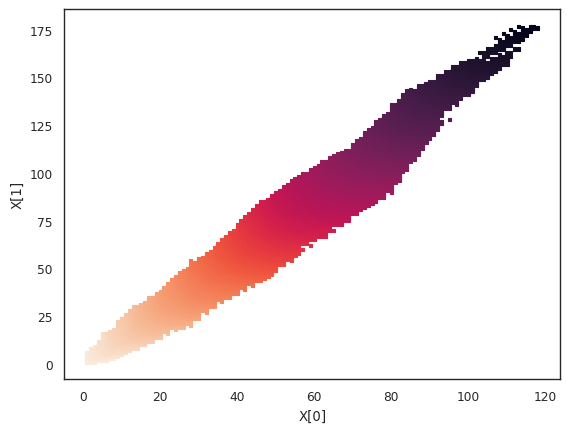

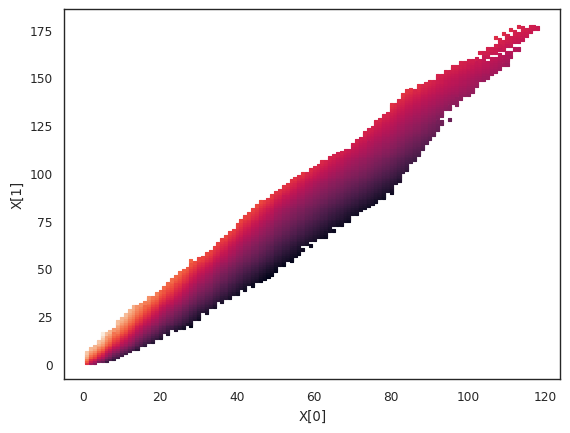

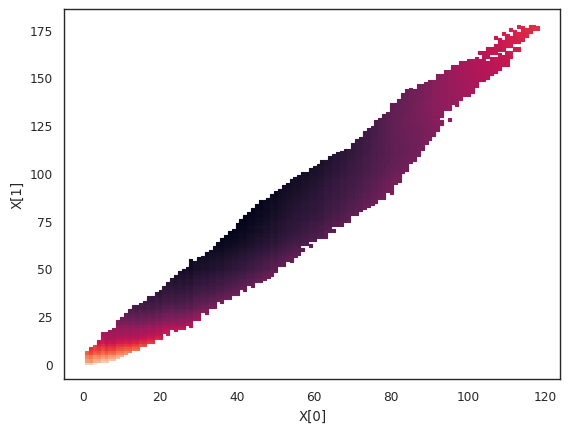

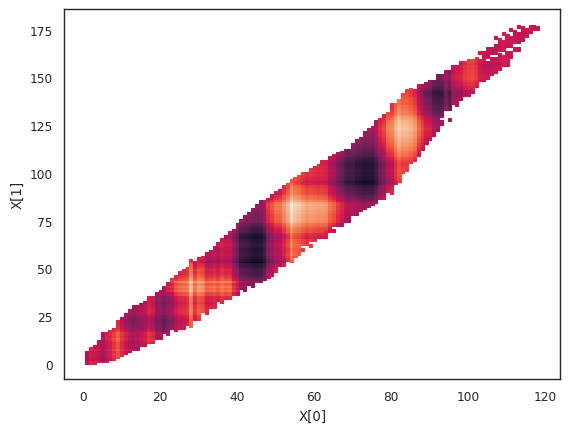

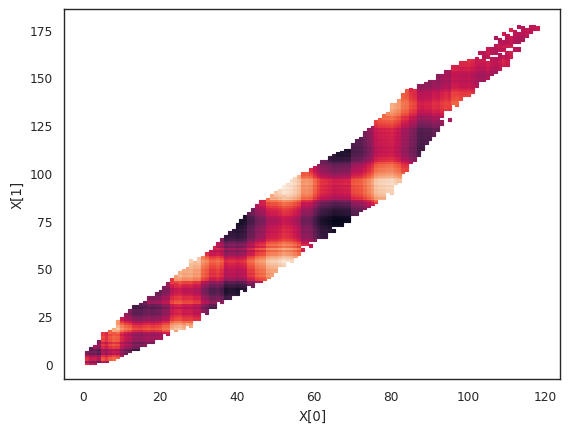

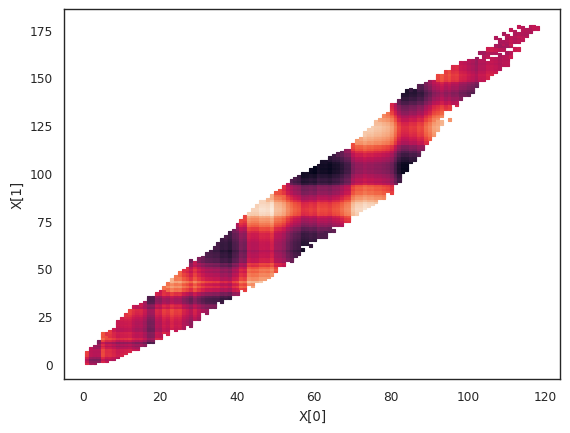

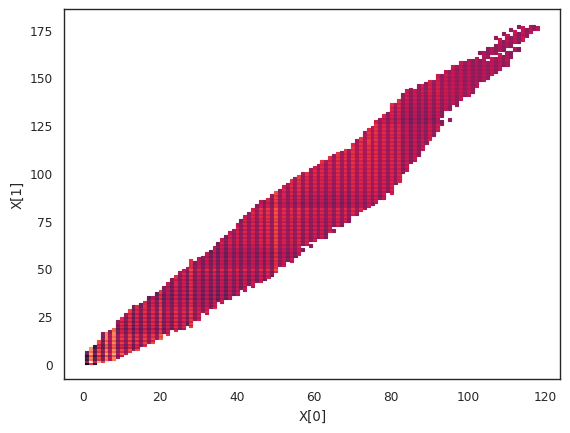

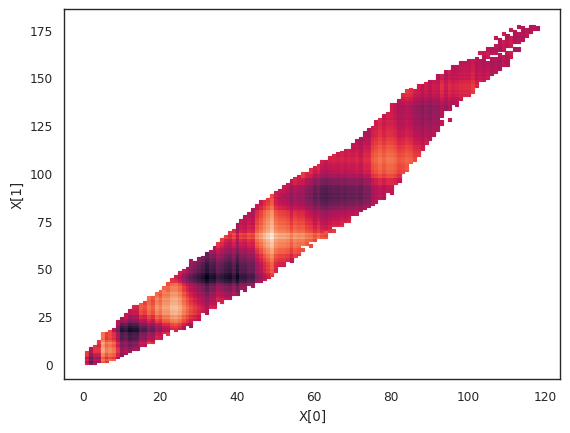

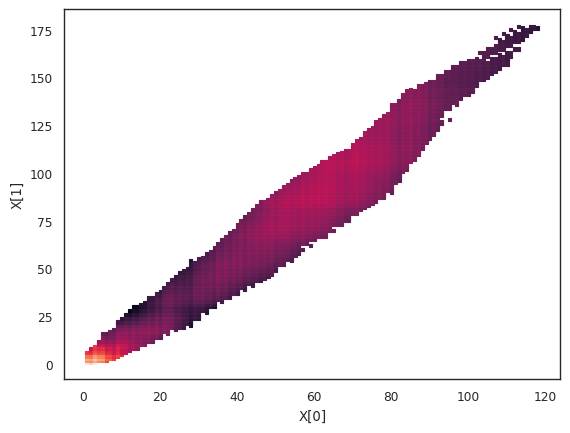

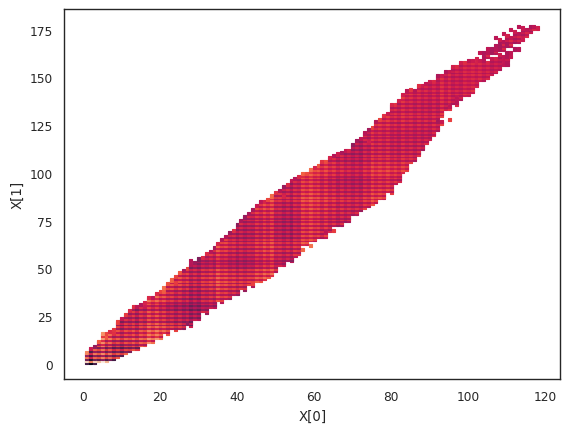

In [5]:
# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0], X[:, 1], c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()

In [6]:
from pysr import PySRRegressor
from functools import partial

sr_factory = partial(PySRRegressor,
    niterations=200,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
        "parity(x) = x % 2",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    ncyclesperiteration=300,
)

In [7]:
pysr_models = []
for i in range(10):
    with open(f"plots/long-runs/all/equations/{i}.pkl", "rb") as f:
        sr = pickle.load(f)
        sr.set_params(extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},)
        sr.refresh()
        pysr_models.append(sr)

In [9]:
FORCE = False


os.makedirs(f"plots/long-runs/{model_name}/equations_powr_laws", exist_ok=True)
inputs = X[:, :2].detach().cpu().numpy()
# fit the symbolic regression model to the data
equations = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(tqdm.tqdm(acts_pca.T)):
        time.sleep(2)
        fname = f"plots/long-runs/{model_name}/equations/{i}.pkl"
        if not os.path.exists(fname) or FORCE:
            sr = sr_factory()
            sr.fit(inputs, feature)
            equations.append(sr)
            # pickle.dump(sr, open(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
        else:
            sr = pickle.load(open(fname, 'rb'))
            sr.set_params(extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},)
            sr.refresh()
            equations.append(sr)

        # make predictions
        lowest_loss_idx = equations[-1].equations_.loss.argmin()
        y_pred = equations[-1].predict(inputs, lowest_loss_idx)
        recomputed_loss = ((feature - y_pred)**2).mean()

        loss = equations[-1].equations_.loss[lowest_loss_idx]
        print(f"Loss: {loss} vs {recomputed_loss}, var: {np.var(feature)}")
print("Done")

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:18,  2.05s/it]

Loss: 0.027218455 vs 0.027218415723052662, var: 30.006174087524414


 20%|██        | 2/10 [00:04<00:16,  2.05s/it]

Loss: 0.0016039481 vs 0.001603949008007812, var: 0.30061617493629456


 30%|███       | 3/10 [00:06<00:14,  2.07s/it]

Loss: 0.0010976493 vs 0.002939111267838423, var: 0.1498243808746338


 40%|████      | 4/10 [00:08<00:12,  2.10s/it]

Loss: 0.010590694 vs 0.024310183203223618, var: 0.03859581798315048


 50%|█████     | 5/10 [00:10<00:10,  2.14s/it]

Loss: 0.011517787 vs 0.01582618923550342, var: 0.030455175787210464


 60%|██████    | 6/10 [00:12<00:08,  2.17s/it]

Loss: 0.008067364 vs 0.17319063838650853, var: 0.023887593299150467


 70%|███████   | 7/10 [00:14<00:06,  2.16s/it]

Loss: 0.0014352321 vs 0.0014352282077885314, var: 0.014537278562784195


 80%|████████  | 8/10 [00:17<00:04,  2.19s/it]

Loss: 0.003935271 vs 0.05998056547344502, var: 0.01086087804287672


 90%|█████████ | 9/10 [00:19<00:02,  2.17s/it]

Loss: 0.0015674443 vs 0.001567444958346836, var: 0.009227683767676353


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

Loss: 0.0012406156 vs 0.017184531451185585, var: 0.007506927475333214
Done


In [ ]:
FORCE = False


os.makedirs(f"plots/long-runs/{model_name}/equations", exist_ok=True)
inputs = X[:, :2].detach().cpu().numpy()
# fit the symbolic regression model to the data
equations = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(tqdm.tqdm(acts_pca.T)):
        time.sleep(2)
        fname = f"plots/long-runs/{model_name}/equations/{i}.pkl"
        if not os.path.exists(fname) or FORCE:
            sr = sr_factory()
            sr.fit(inputs, feature)
            equations.append(sr)
            # pickle.dump(sr, open(fname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
        else:
            sr = pickle.load(open(fname, 'rb'))
            sr.set_params(extra_sympy_mappings={"inv": lambda x: 1 / x, "parity": lambda x: x % 2},)
            sr.refresh()
            equations.append(sr)

        # make predictions
        lowest_loss_idx = equations[-1].equations_.loss.argmin()
        y_pred = equations[-1].predict(inputs, lowest_loss_idx)
        recomputed_loss = ((feature - y_pred)**2).mean()

        loss = equations[-1].equations_.loss[lowest_loss_idx]
        print(f"Loss: {loss} vs {recomputed_loss}, var: {np.var(feature)}")
print("Done")

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:19,  2.14s/it]

Loss: 0.004097887 vs 0.004097903646629863, var: 30.006174087524414


 20%|██        | 2/10 [00:04<00:16,  2.09s/it]

Loss: 0.0018990115 vs 0.0018990090135858407, var: 0.30061596632003784


 30%|███       | 3/10 [00:06<00:14,  2.08s/it]

Loss: 0.0022959511 vs 0.0022959524017006246, var: 0.14982429146766663


 40%|████      | 4/10 [00:08<00:12,  2.07s/it]

Loss: 0.007118241 vs 0.007118249361352263, var: 0.03859580680727959


 50%|█████     | 5/10 [00:10<00:10,  2.07s/it]

Loss: 0.0041159377 vs 0.004115935977749522, var: 0.030455179512500763


 60%|██████    | 6/10 [00:12<00:08,  2.07s/it]

Loss: 0.0035938749 vs 0.0035938720351695874, var: 0.02388763427734375


 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

Loss: 0.0016189568 vs 0.0016189554284646178, var: 0.014537299051880836


 80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

Loss: 0.0020239998 vs 0.0020239849626763093, var: 0.010860889218747616


 90%|█████████ | 9/10 [00:18<00:02,  2.07s/it]

Loss: 0.0020510904 vs 0.0021053339692256095, var: 0.009227685630321503


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

Loss: 0.0013466107 vs 0.0013465854329037694, var: 0.007506934460252523
Done


In [10]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds_from_acts(acts):
    pred = model.readout(acts)
    pred = inverse_transform(pred, data)
    return pred[:, 0]

In [15]:
# combine the predictions of the symbolic regression models
# into a vector of features and use the same linear regression parameters from before
# to predict the output
sr_features = np.zeros((len(inputs), len(equations)))
for i, (sr, feat) in enumerate(zip(equations, acts_pca.T)):
    # idx = sr.equations_.score.values.argsort()[::-1][0] # select the best pareto front
    # idx = sr.equations_.loss.values.argsort()[0] # select the best equation by loss
    # pred = sr.predict(inputs, idx)
    pred = sr.predict(inputs)
    if i == 0:
        print((((pred - feat)**2).mean()), feat.std()**2)
    sr_features[:, i] = pred
sr_features = torch.tensor(sr_features, device=args.DEV).float()

# We will get predictions in three different ways:
# 1. use the model readout layer
# 2. use a linear regression directly to the target
# 3. use a linear regression from the original PCA features

# 1. use the model readout layer
sr_features[:, 3:] = 0
acts = pca.inverse_transform(sr_features.detach().cpu().numpy())
acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print("Model readout layer", (pred - y).pow(2).mean().sqrt().item())


# 2. use a linear regression directly to the target
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(sr_features.detach().cpu().numpy(), y.detach().cpu().numpy())
pred = lr.predict(sr_features.detach().cpu().numpy())
print("Linear regression", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)
print()

0.027218415723052662 30.006171508724947
Model readout layer 15907.188577220413
Linear regression 15658.615008997444



In [ ]:
# combine the predictions of the symbolic regression models
# into a vector of features and use the same linear regression parameters from before
# to predict the output
sr_features = np.zeros((len(inputs), len(equations)))
for i, (sr, feat) in enumerate(zip(equations, acts_pca.T)):
    # idx = sr.equations_.score.values.argsort()[::-1][0] # select the best pareto front
    # idx = sr.equations_.loss.values.argsort()[0] # select the best equation by loss
    # pred = sr.predict(inputs, idx)
    pred = sr.predict(inputs)
    if i == 0:
        print((((pred - feat)**2).mean()), feat.std()**2)
    sr_features[:, i] = pred
sr_features = torch.tensor(sr_features, device=args.DEV).float()

# We will get predictions in three different ways:
# 1. use the model readout layer
# 2. use a linear regression directly to the target
# 3. use a linear regression from the original PCA features

# 1. use the model readout layer
sr_features[:, 3:] = 0
acts = pca.inverse_transform(sr_features.detach().cpu().numpy())
acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print("Model readout layer", (pred - y).pow(2).mean().sqrt().item())


# 2. use a linear regression directly to the target
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(sr_features.detach().cpu().numpy(), y.detach().cpu().numpy())
pred = lr.predict(sr_features.detach().cpu().numpy())
print("Linear regression", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)
print()

0.004097903646629863 30.006171508724947
Model readout layer 6736.750888230277
Linear regression 6720.746982292965



In [12]:
# save the linear regression coefficients
IO.dump_pickle(lr.coef_, f"plots/long-runs/{model_name}/equations/lr-coefs.pkl")
# save the data from the symbolic regression
# save latex expression of the symbolic regression and the full_table
for i, eq in enumerate(equations):
    np.save(f"plots/long-runs/{model_name}/equations/{i}.npy", acts_pca[:, i])
    # save symbolic regression object
    eq.equations_.to_csv(f"plots/long-runs/{model_name}/equations/{i}.csv")
    # tex 
    open(f"plots/long-runs/{model_name}/equations/{i}.tex", 'w').write(eq.latex())
# save inputs
np.save(f"plots/long-runs/{model_name}/equations/inputs.npy", inputs)
# write .txt file to explain what each file here is
with open(f"plots/long-runs/{model_name}/equations/readme.txt", 'w') as f:
    f.write(f"""This folder contains the symbolic regression results for the model model_name=`{model_name}`.
Each file is the feature extracted from the model's penultimate layer for a given PC.
The file lr-coefs.pkl contains the coefficients of the linear regression model that
combines these features to predict the target.
N.pkl files are PySRRegressor objects that can be loaded with pickle.load where N is the index of the PC.
N.npy files are the PC features, ordered by PC index.
N.tex files are the latex expressions of the best SR model.
N.csv files are the full table of PySR model.    
inputs.npy is the input data used to train the SR models.
""")


ValueError: 
0.0430 \cdot 0.718^{- 0.562 x_{0} + 0.438 x_{1}} - 0.196 \left(x_{0} + x_{1} + 0.549\right)^{0.847} - \left(0.196 \left(1.22 \left(0.481 x_{1} + 1\right)^{0.277} \bmod 2\right)\right) + 12.7
                                                                                                                                                                  ^
ParseSyntaxException: Expected '\\right', found '\'  (at char 162), (line:1, col:163)

<Figure size 640x480 with 1 Axes>

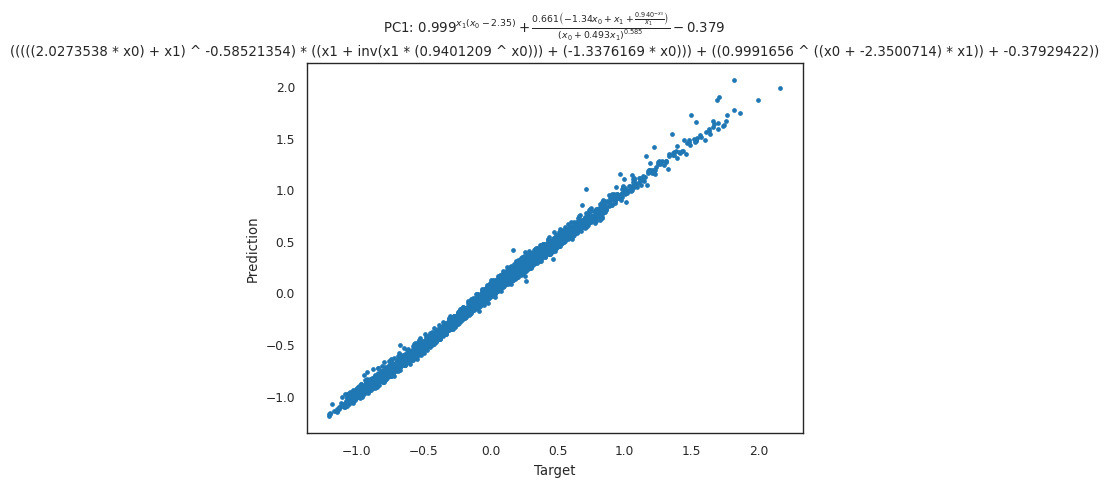

ValueError: 
0.439^{x_{1} + 2.30} x_{0} x_{1} + \left(\left(0.974^{x_{1}} - 1.42\right) \left(- 0.0175 x_{0} - \left(0.0175 \left(\left(0.801 - 0.0221 x_{1}\right) \bmod 2\right)\right) + 3.74\right)\right) + 3.26
                                                                                                                                                       ^
ParseSyntaxException: Expected '\\right', found '\'  (at char 151), (line:1, col:152)

<Figure size 640x480 with 1 Axes>

In [13]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
for pc_idx in range(3):
    idx = equations[pc_idx].equations_.loss.argmin()
    function = equations[pc_idx].equations_.equation[idx]
    latex = equations[pc_idx].latex(idx)
    preds = equations[pc_idx].predict(inputs, idx)
    tgt = acts_pca[:, pc_idx]
    plt.plot(tgt, preds, '.')
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.title(f"PC{pc_idx}: " + f"${latex}$" + "\n" + \
              function)
    plt.show()

In [16]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
# acts_pca[:, 1:] = 0
acts = pca.inverse_transform(acts_pca)

acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print((pred - y).pow(2).mean().sqrt())

tensor(965.6178, dtype=torch.float64, grad_fn=<SqrtBackward0>)


In [ ]:
for pc_idx in range(3):
    idx = equations[pc_idx].equations_.loss.argmin()
    print(pc_idx)
    print(equations[pc_idx].latex(idx))

0
\left(1.07 \cdot 10^{-6} x_{0}^{2} - 0.0913\right) \left(x_{0} \sin{\left(\frac{1.03 \cdot \left(1.07 x_{1} + 2.61\right)}{x_{0} + \frac{1}{x_{0}}} \right)} + x_{1} + 1.61\right) + 11.9
1
\frac{- 1.41 x_{0} + x_{1} + 4.99 \sin{\left(0.0355 x_{1} + 1.22 \right)} + 0.202 - \frac{1.41}{x_{1}}}{0.257 x_{0} + 0.0356 x_{1} + 4.85}
2
\left(1.10 - 0.0599 x_{1}\right) \left(- 0.00168 x_{0} + \sin{\left(\frac{1}{0.0619 x_{0} + \frac{1}{x_{0}}} \right)}\right) + \sin{\left(\frac{x_{0}}{x_{1}^{2} + 2.01} + 0.404 \right)}


In [13]:
acts = get_penultimate_acts(model, X)
acts = acts.detach().cpu().numpy()
acts_pca = pca.transform(acts)
# acts_pca[:, 1:] = 0
acts = pca.inverse_transform(acts_pca)

acts = torch.tensor(acts, device=args.DEV).float()
pred = get_preds_from_acts(acts)
print((pred - y).pow(2).mean().sqrt())

tensor(965.6216, dtype=torch.float64, grad_fn=<SqrtBackward0>)


In [17]:
for pc_idx in range(3):
    idx = equations[pc_idx].equations_.loss.argmin()
    print(pc_idx)
    print(equations[pc_idx].latex(idx))

0
0.0430 \cdot 0.718^{- 0.562 x_{0} + 0.438 x_{1}} - 0.196 \left(x_{0} + x_{1} + 0.549\right)^{0.847} - \left(0.196 \left(1.22 \left(0.481 x_{1} + 1\right)^{0.277} \bmod 2\right)\right) + 12.7
1
0.999^{x_{1} \left(x_{0} - 2.35\right)} + \frac{0.661 \left(- 1.34 x_{0} + x_{1} + \frac{0.940^{- x_{0}}}{x_{1}}\right)}{\left(x_{0} + 0.493 x_{1}\right)^{0.585}} - 0.379
2
0.439^{x_{1} + 2.30} x_{0} x_{1} + \left(\left(0.974^{x_{1}} - 1.42\right) \left(- 0.0175 x_{0} - \left(0.0175 \left(\left(0.801 - 0.0221 x_{1}\right) \bmod 2\right)\right) + 3.74\right)\right) + 3.26


In [15]:
for pc_idx in range(3):
    idx = equations[pc_idx].equations_.loss.argmin()
    print(idx)
    print(equations[pc_idx].latex(idx))

27
\left(1.07 \cdot 10^{-6} x_{0}^{2} - 0.0913\right) \left(x_{0} \sin{\left(\frac{1.03 \cdot \left(1.07 x_{1} + 2.61\right)}{x_{0} + \frac{1}{x_{0}}} \right)} + x_{1} + 1.61\right) + 11.9
26
\frac{- 1.41 x_{0} + x_{1} + 4.99 \sin{\left(0.0355 x_{1} + 1.22 \right)} + 0.202 - \frac{1.41}{x_{1}}}{0.257 x_{0} + 0.0356 x_{1} + 4.85}
25
\left(1.10 - 0.0599 x_{1}\right) \left(- 0.00168 x_{0} + \sin{\left(\frac{1}{0.0619 x_{0} + \frac{1}{x_{0}}} \right)}\right) + \sin{\left(\frac{x_{0}}{x_{1}^{2} + 2.01} + 0.404 \right)}


In [16]:
# now let's do direct SR on the final target
sr = sr_factory()
sr.fit(inputs, y.detach().cpu().numpy())


Compiling Julia backend...


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:162: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
Juliaup configuration is locked by another process, waiting for it to unlock.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python lib

Started!

Expressions evaluated per second: 1.300e+05
Head worker occupation: 63.7%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 355 / 3000 total iterations (11.833%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.576e+11  1.594e+01  y = 1.1005e+06
3           7.320e+09  1.780e+00  y = (19103 * x₀)
5           3.231e+09  4.089e-01  y = ((x₀ + x₁) * 7835.9)
7           2.046e+09  2.283e-01  y = ((x₀ + (x₁ + 10.518)) * 7385.1)
9           2.046e+09  1.240e-05  y = ((((x₁ + 10.509) + x₀) * 7385.2) + x₀)
11          2.011e+09  8.808e-03  y = (((x₁ + 10.509) + x₀) * (7385.2 + (-0.51923 * x₀)))
12          1.727e+09  1.518e-01  y = (((x₁ + 10.517) + (x₀ + sin(x₀ * -0.079692))) * 7385.2)
---------------------------------------------------------------------------------------------------
Pr

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        1.1004751e6   
	1         1.780376                                   (19102.855 * x0)   
	2         0.408950                            ((x0 + x1) * 7835.8755)   
	3         0.228329              ((x0 + (x1 + 10.517659)) * 7385.1475)   
	4         0.750234       ((9131.963 + (-16.496584 * x0)) * (x1 + x0))   
	5         0.225835  (((-21.875591 * x0) + 9793.05) * ((x1 + x0) + ...   
	6         0.000125  ((((-21.875296 * x0) + 9792.622) * ((x1 + x0) ...   
	7         0.001792  (((-21.876513 * x0) + 9792.373) * ((x1 + (x0 +...   
	8   >>>>  0.230690  (((-14.093701 * x0) + (9788.316 + (-5.144038 *...   
	9         0.000053  ((((-14.093701 * x0) + -1.1822762) + (9788.316...   
	10        0.003743  (((-14.093701 * x0) + (9788.316 + (-5.144038 *...   
	11        0.000096  (((-14.093701 * x0) + (9788.316 + ((-5.144038 ...   
	
	            loss  complexity  
	0   2.575917e+11           1  
	1   7.320104e+09           3  
	2   3.230785e+09           5  
	3   2.046369e+09           7  
	4   4.563931e+08           9  
	5   2.905234e+08          11  
	6   2.904508e+08          13  
	7   2.899307e+08          14  
	8   2.302008e+08          15  
	9   2.301764e+08          17  
	10  2.293165e+08          18  
	11  2.292723e+08          20  
]

In [17]:
pred = sr.predict(inputs, sr.equations_.loss.argmin())
print("SR", ((pred - y.detach().cpu().numpy())**2).mean()**0.5)

SR 15141.738813871118


In [18]:
# semf rms
Z, N = inputs.T
preds = (semi_empirical_mass_formula(Z, N))* (N+Z)
print("SEMF", ((preds - y.detach().cpu().numpy())**2).mean()**0.5)

SEMF 7928.02400004463
